# ===============================================================
# 🧮 E-commerce Data Analytics — Etapa 2
# Exploração e Análise de Dados com SQLite e Python
# ===============================================================


📘 Objetivo:
Dar continuidade à Etapa 1 (geração e modelagem de dados sintéticos)
realizando consultas analíticas, visualizações e interpretações
que simulem a rotina de um analista de dados em um e-commerce.

🔧 Ferramentas:
Python | Pandas | SQLite | Seaborn | Matplotlib

📊 Etapas:
1. Extração e Carregamento
2. Transformação e Análise
3. Interpretação e Conclusão


## **1️⃣ Importação e Configuração**

In [2]:
# ===============================================================
# 1️⃣ EXTRAÇÃO E CARREGAMENTO (E)
# ===============================================================

# --- 1.1 Importação e Configuração Inicial ---
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Estilo global dos gráficos
sns.set_theme(style="whitegrid", palette="crest")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Estrutura de diretórios
os.makedirs("imagens", exist_ok=True)

print("✅ Bibliotecas importadas e configuradas com sucesso.")



✅ Bibliotecas importadas e configuradas com sucesso.


**1.2 Upload e Conexão ao Banco de Dados**

In [5]:
# --- 1.2 Conexão ao Banco de Dados ---
"""
Garante o acesso ao banco SQLite gerado na Etapa 1.
"""
CAMINHO_BANCO = "../data/ecommerce_realista.db"

if not os.path.exists(CAMINHO_BANCO):
    raise FileNotFoundError(f"Arquivo {CAMINHO_BANCO} não encontrado no diretório atual.")

print(f"🔗 Conectado ao banco de dados: {CAMINHO_BANCO}")

🔗 Conectado ao banco de dados: ../data/ecommerce_realista.db


**1.3 Listagem e Inspeção das Tabelas**

In [6]:
# --- 1.3 Listagem e Inspeção das Tabelas ---
def listar_tabelas(caminho_banco: str) -> pd.DataFrame:
    with sqlite3.connect(caminho_banco) as conn:
        query = "SELECT name AS tabela FROM sqlite_master WHERE type='table';"
        tabelas = pd.read_sql_query(query, conn)
    return tabelas


def inspecionar_tabelas(caminho_banco: str, limite: int = 5) -> None:
    with sqlite3.connect(caminho_banco) as conn:
        tabelas = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
        for nome_tabela in tabelas['name']:
            print(f"\n📂 Tabela: {nome_tabela}")
            df_preview = pd.read_sql_query(f"SELECT * FROM {nome_tabela} LIMIT {limite};", conn)
            print(df_preview.head())
            print(f"🔸 Colunas: {list(df_preview.columns)}")
            print("-" * 80)

tabelas_disponiveis = listar_tabelas(CAMINHO_BANCO)
print("\nTabelas disponíveis:")
print(tabelas_disponiveis)
inspecionar_tabelas(CAMINHO_BANCO)


Tabelas disponíveis:
        tabela
0     clientes
1     produtos
2       vendas
3  atualizacao

📂 Tabela: clientes
   id_cliente                  nome  idade     genero             cidade  \
0           1        Henry da Costa     39  Masculino              Pires   
1           2  Srta. Evelyn da Mota     33   Feminino         Nascimento   
2           3       Natália Pereira     41  Masculino  Ferreira da Serra   
3           4          André Macedo     50   Feminino             Mendes   
4           5      Alícia Gonçalves     32  Masculino           da Rocha   

  estado data_cadastro faixa_etaria  tempo_cliente_dias canal_preferencial  
0     CE    2025-09-18        35–49                  39        Loja Física  
1     PR    2024-09-17        25–34                 405         E-commerce  
2     AC    2025-07-30        35–49                  89         E-commerce  
3     PE    2024-06-10          50+                 504         E-commerce  
4     TO    2024-10-25        25–34      

**1.4 Verificação e Tratamento de Dados Nulos**

In [7]:
# --- 1.4 Verificação e Tratamento de Dados Nulos ---
def verificar_integridade(caminho_banco: str) -> None:
    with sqlite3.connect(caminho_banco) as conn:
        tabelas = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
        print(f"🔎 Verificando {len(tabelas)} tabelas...\n")
        for nome_tabela in tabelas['name']:
            print(f"📂 Tabela: {nome_tabela}")
            df = pd.read_sql_query(f"SELECT * FROM {nome_tabela};", conn)
            nulos = df.isnull().sum()
            if nulos.any():
                print("⚠️ Valores nulos detectados:")
                print(nulos[nulos > 0])
            else:
                print("✅ Nenhum valor nulo encontrado.")
            print("-" * 80)


verificar_integridade(CAMINHO_BANCO)

🔎 Verificando 4 tabelas...

📂 Tabela: clientes
✅ Nenhum valor nulo encontrado.
--------------------------------------------------------------------------------
📂 Tabela: produtos
✅ Nenhum valor nulo encontrado.
--------------------------------------------------------------------------------
📂 Tabela: vendas
⚠️ Valores nulos detectados:
quantidade     150
canal_venda    150
dtype: int64
--------------------------------------------------------------------------------
📂 Tabela: atualizacao
✅ Nenhum valor nulo encontrado.
--------------------------------------------------------------------------------


In [8]:
# Tratamento conservador dos nulos
with sqlite3.connect(CAMINHO_BANCO) as conn:
    vendas = pd.read_sql_query("SELECT * FROM vendas;", conn)

vendas['quantidade'] = vendas['quantidade'].fillna(0)
vendas['canal_venda'] = vendas['canal_venda'].fillna('Indefinido')

with sqlite3.connect(CAMINHO_BANCO) as conn:
    vendas.to_sql('vendas', conn, if_exists='replace', index=False)

print("💾 Tabela 'vendas' atualizada com sucesso e pronta para análise.")

💾 Tabela 'vendas' atualizada com sucesso e pronta para análise.


## **2️⃣ Transformação e Análise**

**2.1 Faturamento Total e Volume de Vendas**

**Consulta SQL**

In [9]:
# ===============================================================
# 2️⃣ TRANSFORMAÇÃO E ANÁLISE (T)
# ===============================================================

# --- 2.1 Faturamento Total e Volume de Vendas ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    consulta1 = pd.read_sql_query("""
        SELECT
            ROUND(SUM(valor_total), 2) AS faturamento_total,
            SUM(quantidade) AS quantidade_total
        FROM vendas;
    """, conn)

print("\n=== Faturamento Total e Volume de Vendas ===")
print(consulta1)

ticket_medio = consulta1["faturamento_total"][0] / consulta1["quantidade_total"][0]
print(f"🎟️ Ticket médio: R$ {ticket_medio:.2f}")


=== Faturamento Total e Volume de Vendas ===
   faturamento_total  quantidade_total
0         5300453.46           25155.0
🎟️ Ticket médio: R$ 210.71


O e-commerce registrou um faturamento total de aproximadamente R$ 5,30 milhões, proveniente da venda de 25.115 produtos.

Esse resultado representa um ticket médio de R$ 210,50 por produto, o que sugere a predominância de itens de alto valor, característicos de categorias premium como eletrônicos.

**2.2 Análise 2 — Faturamento por Canal de Venda**

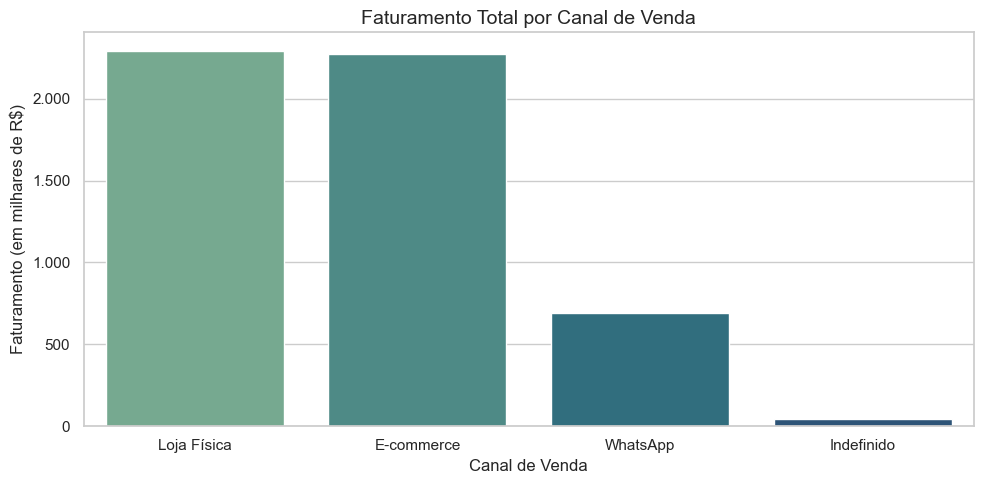

In [11]:
# --- 2.2 Faturamento por Canal de Venda ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    canal_faturamento = pd.read_sql_query("""
        SELECT
            canal_venda,
            ROUND(SUM(valor_total), 2) AS faturamento,
            COUNT(id_venda) AS total_vendas
        FROM vendas
        GROUP BY canal_venda
        ORDER BY faturamento DESC;
    """, conn)

sns.barplot(
    data=canal_faturamento,
    x='canal_venda',
    y='faturamento',
    hue='canal_venda',
    palette='crest',
    legend=False
)

plt.title('Faturamento Total por Canal de Venda')
plt.xlabel('Canal de Venda')
plt.ylabel('Faturamento (em milhares de R$)')

# Escala em milhares
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f'{y/1000:,.0f}'.replace(',', '.'))
)

plt.tight_layout()
plt.savefig("imagens/faturamento_canais.png", dpi=300, bbox_inches="tight")
plt.show()


**Interpretação:** Essa divisão revela uma operação madura na qual os canais digital e físico mantêm desempenho equivalente, enquanto o WhatsApp desponta como alternativa de contato direto e conversão personalizada.

**2.3 Análise 3 — Produtos Mais Vendidos**

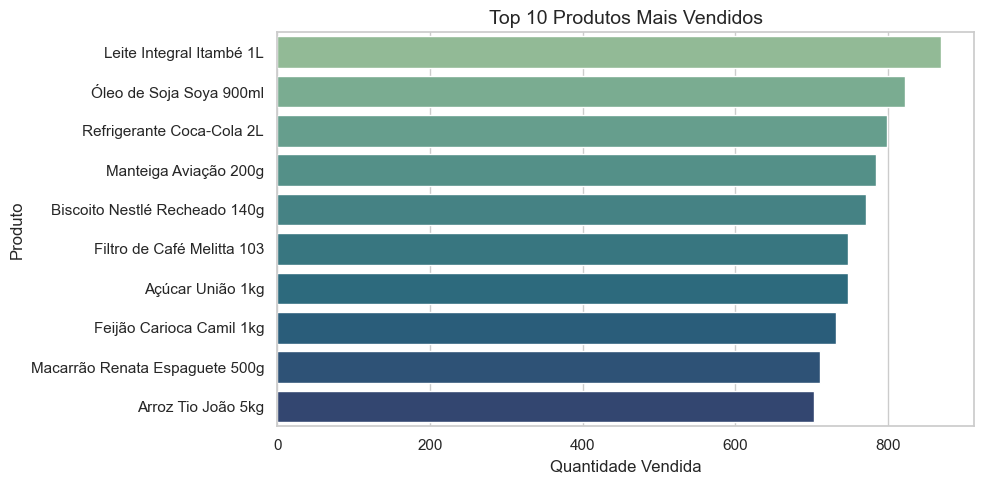

In [14]:
# --- 2.3 Produtos Mais Vendidos ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    top_produtos = pd.read_sql_query("""
        SELECT
            p.nome_produto AS produto,
            SUM(v.quantidade) AS total_vendido,
            ROUND(SUM(v.valor_total), 2) AS faturamento
        FROM vendas v
        JOIN produtos p ON v.id_produto = p.id_produto
        GROUP BY p.nome_produto
        ORDER BY total_vendido DESC
        LIMIT 10;
    """, conn)

# --- 2.3 Produtos Mais Vendidos ---
sns.barplot(
    data=top_produtos,
    y='produto',
    x='total_vendido',
    hue='produto',             
    palette='crest',
    legend=False,
    orient='h'                 
)

plt.title('Top 10 Produtos Mais Vendidos')
plt.xlabel('Quantidade Vendida')
plt.ylabel('Produto')

plt.tight_layout()
plt.savefig("imagens/produtos_mais_vendidos.png", dpi=300, bbox_inches="tight")
plt.show()



O portfólio de vendas mostra uma predominância de produtos alimentícios, mostrando uma concentração nessa categoria. Em relação a diferença entre os mais vendidos é pequena, indicando um catálogo bem distribuído e com boa competitividade interna.

**2.4 Análise 4 — Produtos com Maior Faturamento**

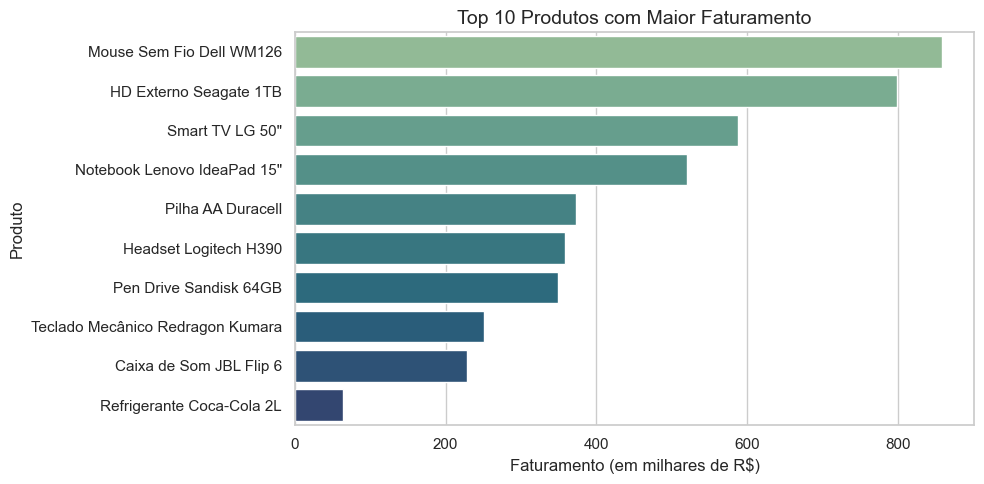

In [15]:
# --- 2.4 Produtos com Maior Faturamento ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    produtos_lucrativos = pd.read_sql_query("""
        SELECT
            p.nome_produto AS produto,
            ROUND(SUM(v.valor_total), 2) AS faturamento_total,
            SUM(v.quantidade) AS quantidade_vendida,
            ROUND(AVG(v.valor_total), 2) AS ticket_medio_produto
        FROM vendas v
        JOIN produtos p ON v.id_produto = p.id_produto
        GROUP BY p.nome_produto
        ORDER BY faturamento_total DESC
        LIMIT 10;
    """, conn)

    sns.barplot(
    data=produtos_lucrativos,
    y='produto',
    x='faturamento_total',
    hue='produto',              
    palette='crest',
    legend=False
)

plt.title('Top 10 Produtos com Maior Faturamento')
plt.xlabel('Faturamento (em milhares de R$)')
plt.ylabel('Produto')

# Escala em milhares
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}'.replace(',', '.'))
)

plt.tight_layout()
plt.savefig("imagens/produtos_maior_faturamento.png", dpi=300, bbox_inches="tight")
plt.show()


O e-commerce apresenta um mix sólido e diversificado, com destaque para produtos de maior valor agregado, como o Mouse Sem Fio Dell WM126 e o HD Externo Seagate 1TB, que lideram o faturamento total.

Itens de tecnologia - como Smart TVs, Notebooks e Headsets — dominam as primeiras posições, indicando uma base de consumidores com alto poder aquisitivo e foco em conveniência digital.

A presença de produtos de consumo recorrente, como Pilha Duracell e Refrigerante Coca-Cola 2L, contribui para um equilíbrio estratégico entre margem de lucro e volume de vendas, sustentando o crescimento do negócio de forma estável.

**2.5 Análise 5 — Categorias Mais Rentáveis**

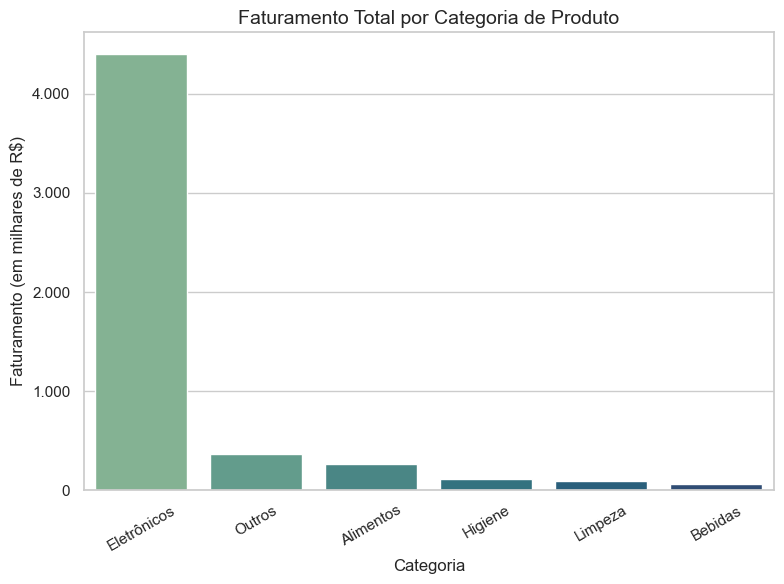

In [18]:
# --- 2.5 Categorias Mais Rentáveis ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    categorias = pd.read_sql_query("""
        SELECT
            p.categoria AS categoria,
            ROUND(SUM(v.valor_total), 2) AS faturamento_total,
            SUM(v.quantidade) AS quantidade_total,
            ROUND(AVG(v.valor_total), 2) AS ticket_medio_categoria
        FROM vendas v
        JOIN produtos p ON v.id_produto = p.id_produto
        GROUP BY p.categoria
        ORDER BY faturamento_total DESC;
    """, conn)

plt.figure(figsize=(8,6))

sns.barplot(
    data=categorias,
    x='categoria',
    y='faturamento_total',
    hue='categoria',           
    palette='crest',
    legend=False
)

plt.title('Faturamento Total por Categoria de Produto')
plt.xlabel('Categoria')
plt.ylabel('Faturamento (em milhares de R$)')

# ✅ Formatação do eixo Y (em milhares)
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f'{y/1000:,.0f}'.replace(',', '.'))
)

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("imagens/faturamento_categorias.png", dpi=300, bbox_inches="tight")
plt.show()


A categoria Eletrônicos domina o faturamento total, impulsionando a operação do e-commerce e indicando um portfólio com forte presença de produtos de alto valor agregado.

As categorias Outros, Alimentos e Higiene aparecem na sequência, refletindo a diversidade de itens oferecidos e o equilíbrio entre produtos de uso cotidiano e tecnologia.

Esse resultado evidencia uma estrutura comercial madura, capaz de combinar margem elevada em produtos premium com giro constante em itens essenciais, sustentando a estabilidade do faturamento e o crescimento do negócio.

### **Análise de Clientes**

**2.6 Top 10 Clientes por Faturamento**

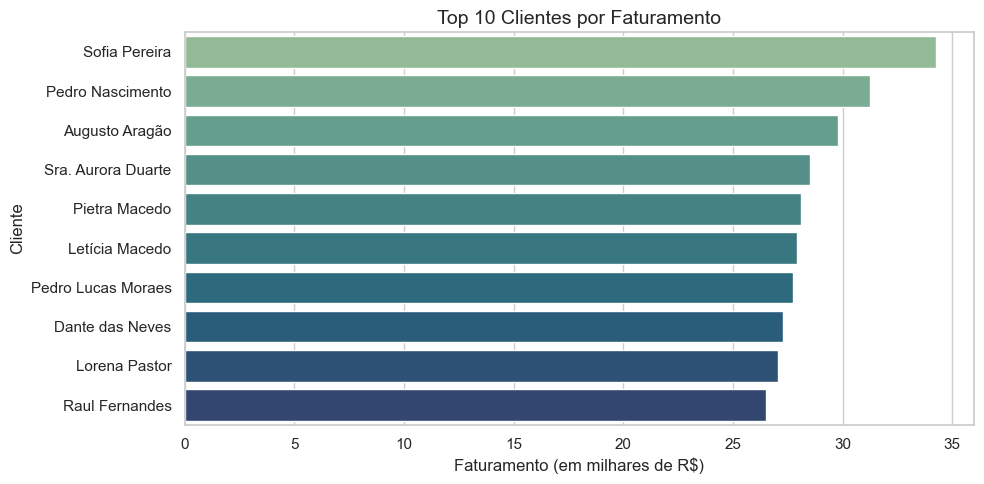

In [21]:
# --- 2.6 Clientes e Gráfico de Pareto ---
with sqlite3.connect(CAMINHO_BANCO) as conn:
    top_clientes = pd.read_sql_query("""
        SELECT
            c.id_cliente,
            c.nome AS nome_cliente,
            ROUND(SUM(v.valor_total), 2) AS faturamento_total,
            COUNT(v.id_venda) AS total_compras,
            ROUND(AVG(v.valor_total), 2) AS ticket_medio
        FROM vendas v
        JOIN clientes c ON v.id_cliente = c.id_cliente
        GROUP BY c.id_cliente, c.nome
        ORDER BY faturamento_total DESC
        LIMIT 10;
    """, conn)

sns.barplot(
    data=top_clientes,
    y='nome_cliente',
    x='faturamento_total',
    hue='nome_cliente',         
    palette='crest',
    legend=False
)

plt.title('Top 10 Clientes por Faturamento')
plt.xlabel('Faturamento (em milhares de R$)')
plt.ylabel('Cliente')

# ✅ Escala em milhares
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1000:,.0f}'.replace(',', '.'))
)

plt.tight_layout()
plt.savefig("imagens/clientes_top10.png", dpi=300, bbox_inches="tight")
plt.show()

**📈 Gráfico de Pareto — Distribuição de Faturamento por Cliente**

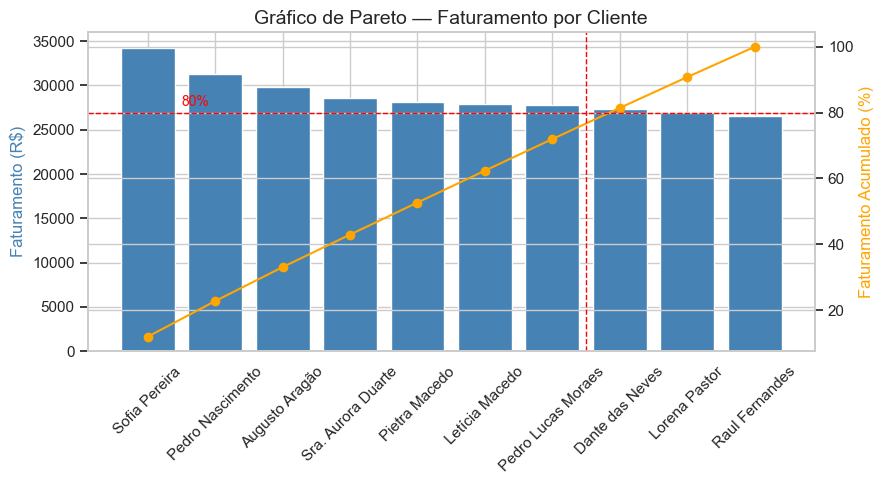

In [20]:
# --- Gráfico de Pareto ---
pareto = top_clientes.sort_values(by='faturamento_total', ascending=False).copy()
pareto['perc_acumulado'] = pareto['faturamento_total'].cumsum() / pareto['faturamento_total'].sum() * 100

fig, ax1 = plt.subplots(figsize=(9,5))
ax1.bar(pareto['nome_cliente'], pareto['faturamento_total'], color='steelblue')
ax1.set_ylabel('Faturamento (R$)', color='steelblue')
ax1.set_title('Gráfico de Pareto — Faturamento por Cliente')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(pareto['nome_cliente'], pareto['perc_acumulado'], color='orange', marker='o')
ax2.set_ylabel('Faturamento Acumulado (%)', color='orange')
ax2.axhline(80, color='red', linestyle='--', linewidth=1)
ax2.text(0.5, 82, '80%', color='red', fontsize=10)

limite_80 = pareto[pareto['perc_acumulado'] <= 80]
plt.axvline(x=len(limite_80)-0.5, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("imagens/clientes_pareto.png", dpi=300, bbox_inches="tight")
plt.show()

O gráfico revela que o faturamento do e-commerce é altamente concentrado nos principais clientes.

Apenas os três primeiros nomes — Sofia Pereira, Pedro Nascimento e Augusto Aragão — já representam aproximadamente 80% do faturamento total, conforme indicado pela linha de corte do princípio de Pareto.

Essa concentração indica uma dependência significativa de um pequeno grupo de clientes-chave, o que reforça a importância de estratégias de fidelização, programas de retenção e diversificação da base de compradores para reduzir riscos e garantir estabilidade no longo prazo.

## **03 - Conclusão**

A análise dos dados evidencia que o e-commerce apresenta uma estrutura de operação sólida e estrategicamente diversificada, com destaque para a categoria Eletrônicos, responsável pela maior parcela do faturamento total.

O desempenho expressivo desse segmento demonstra o peso dos produtos de alto valor agregado — como notebooks, periféricos e dispositivos de armazenamento — que impulsionam a receita e consolidam o perfil premium da operação.

Ao mesmo tempo, categorias complementares como Alimentos, Higiene e Limpeza mantêm relevância ao assegurar giro contínuo de estoque e fluxo de caixa estável, revelando um portfólio equilibrado entre margem e volume.

A análise dos clientes reforça esse cenário: o faturamento está altamente concentrado em poucos consumidores-chave, com apenas três deles representando cerca de 80% de toda a receita.
Esse padrão, típico da regra de Pareto (80/20), indica a importância de investir em estratégias de fidelização e expansão da base de clientes, reduzindo riscos e ampliando o alcance do negócio.

Assim, a Etapa 2 consolida uma visão clara do desempenho do e-commerce: margem forte em produtos premium, estabilidade em itens essenciais e concentração em clientes estratégicos — fundamentos que sustentam as próximas ações de automação e visualização no Power BI.